In [1]:
import pandas as pd

df = pd.read_csv("../data/creditcard.csv")
df.shape

(284807, 31)

In [2]:
import sys
print(sys.executable)

/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/bin/python


In [3]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [4]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

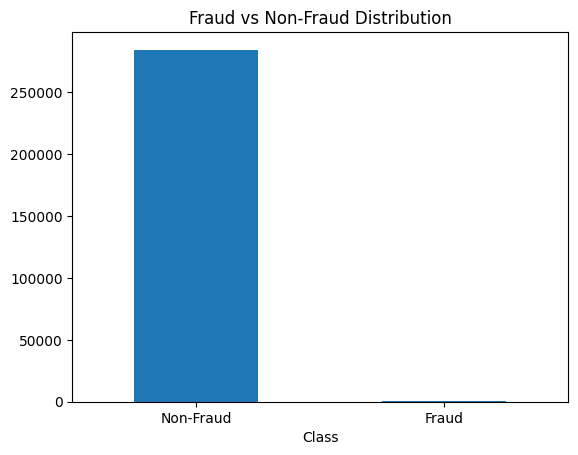

In [5]:
import matplotlib.pyplot as plt

df['Class'].value_counts().plot(kind='bar')
plt.title("Fraud vs Non-Fraud Distribution")
plt.xticks([0,1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

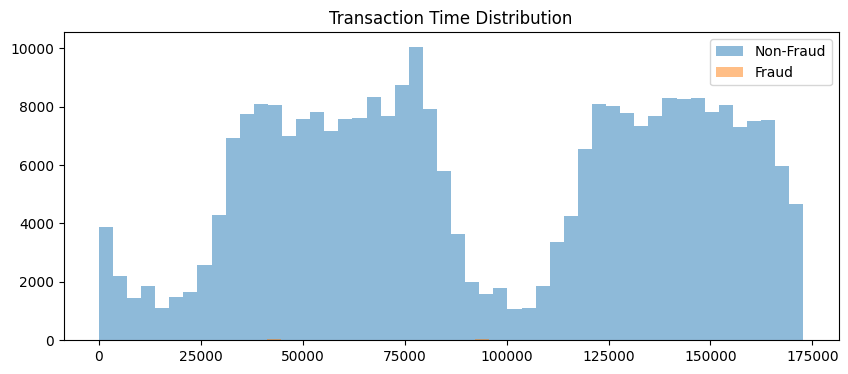

In [6]:
plt.figure(figsize=(10,4))
plt.hist(df[df['Class']==0]['Time'], bins=50, alpha=0.5, label='Non-Fraud')
plt.hist(df[df['Class']==1]['Time'], bins=50, alpha=0.5, label='Fraud')
plt.legend()
plt.title("Transaction Time Distribution")
plt.show()

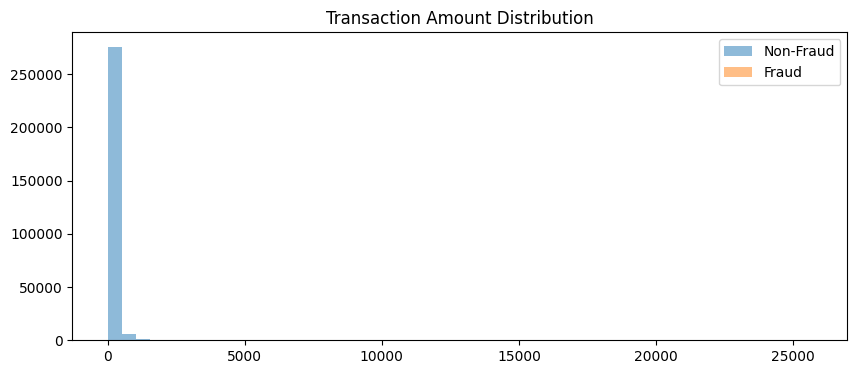

In [7]:
plt.figure(figsize=(10,4))
plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.5, label='Non-Fraud')
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.5, label='Fraud')
plt.legend()
plt.title("Transaction Amount Distribution")
plt.show()

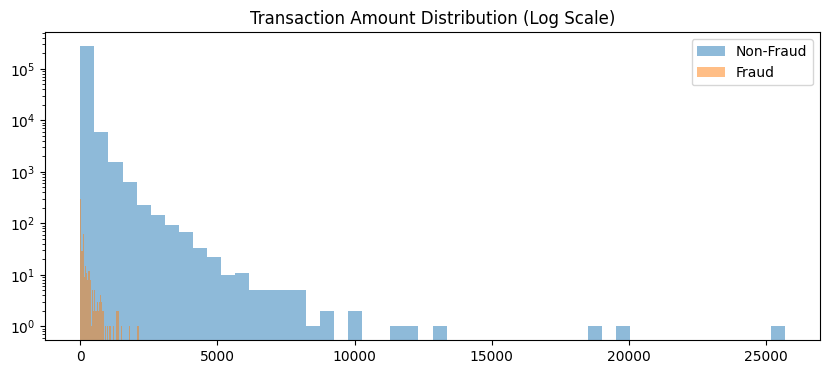

In [8]:
plt.figure(figsize=(10,4))

plt.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.5, label='Non-Fraud')
plt.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.5, label='Fraud')

plt.yscale('log')   # 👈 关键
plt.legend()
plt.title("Transaction Amount Distribution (Log Scale)")
plt.show()

## Observations

1. The dataset is highly imbalanced with only 0.17% fraud cases.
2. Fraud transactions appear to concentrate in lower transaction amounts.
3. The transaction amount distribution is highly right-skewed with extreme outliers in non-fraud transactions.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:, 1]

/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/s

In [25]:
print(type(lr))
print(lr.named_steps.keys())

<class 'sklearn.pipeline.Pipeline'>
dict_keys(['scaler', 'clf'])


In [24]:
model = LogisticRegression(max_iter=2000, class_weight='balanced')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/s

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/sit

In [15]:
from sklearn.metrics import classification_report, average_precision_score

# 1) 先拿到“预测为 fraud 的概率”
y_prob = model.predict_proba(X_test)[:, 1]

# 2) 看 PR-AUC（适合不平衡数据）
print("PR-AUC:", average_precision_score(y_test, y_prob))

# 3) 试不同 threshold
for t in [0.5, 0.4, 0.3, 0.2, 0.1]:
    y_pred_t = (y_prob >= t).astype(int)
    print("\nThreshold:", t)
    print(classification_report(y_test, y_pred_t, digits=3))

PR-AUC: 0.7189358629650895

Threshold: 0.5
              precision    recall  f1-score   support

           0      1.000     0.976     0.988     56864
           1      0.061     0.918     0.114        98

    accuracy                          0.975     56962
   macro avg      0.530     0.947     0.551     56962
weighted avg      0.998     0.975     0.986     56962


Threshold: 0.4
              precision    recall  f1-score   support

           0      1.000     0.964     0.982     56864
           1      0.042     0.918     0.081        98

    accuracy                          0.964     56962
   macro avg      0.521     0.941     0.531     56962
weighted avg      0.998     0.964     0.980     56962


Threshold: 0.3
              precision    recall  f1-score   support

           0      1.000     0.944     0.971     56864
           1      0.027     0.918     0.053        98

    accuracy                          0.943     56962
   macro avg      0.514     0.931     0.512     56962

/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/xiaochi/Downloads/github repo/fraud-anomaly-ds/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [16]:
from sklearn.metrics import confusion_matrix

def show_metrics(threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    print(f"\nThreshold={threshold}")
    print(f"TP={tp}, FP={fp}, FN={fn}, TN={tn}")
    print(f"Precision={precision:.4f}, Recall={recall:.4f}")

for t in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1]:
    show_metrics(t)


Threshold=0.9
TP=87, FP=266, FN=11, TN=56598
Precision=0.2465, Recall=0.8878

Threshold=0.7
TP=89, FP=644, FN=9, TN=56220
Precision=0.1214, Recall=0.9082

Threshold=0.5
TP=90, FP=1390, FN=8, TN=55474
Precision=0.0608, Recall=0.9184

Threshold=0.3
TP=90, FP=3212, FN=8, TN=53652
Precision=0.0273, Recall=0.9184

Threshold=0.2
TP=92, FP=5531, FN=6, TN=51333
Precision=0.0164, Recall=0.9388

Threshold=0.1
TP=93, FP=11341, FN=5, TN=45523
Precision=0.0081, Recall=0.9490


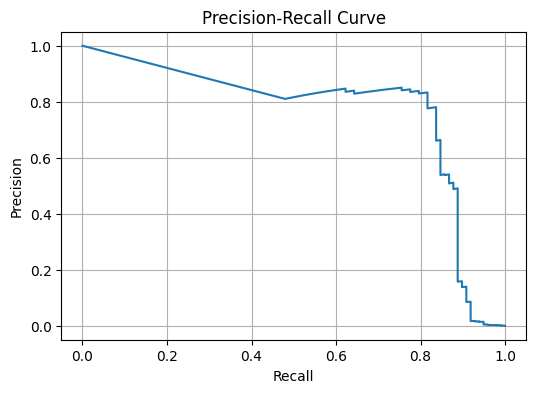

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

prec, rec, thr = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

## Observations from Baseline Modeling

1. The dataset is extremely imbalanced (0.17% fraud cases), making accuracy an unreliable metric.

2. Logistic Regression without class weighting achieved high accuracy but moderate recall (~0.64), missing a significant portion of fraud cases.

3. Applying class_weight='balanced' significantly increased recall (~0.92), but drastically reduced precision, introducing a large number of false positives.

4. Threshold tuning revealed a clear precision-recall trade-off:
   - Lower thresholds increased recall but produced excessive false positives.
   - Higher thresholds (e.g., 0.9) provided a more practical operating point with manageable false positives while maintaining high recall.

5. The Precision-Recall curve indicates that the model has reasonable ranking capability (PR-AUC ≈ 0.72), but performance degrades rapidly in high-recall regions.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

rf_prob = rf.predict_proba(X_test)[:, 1]

In [19]:
from sklearn.metrics import average_precision_score

rf_ap = average_precision_score(y_test, rf_prob)
print("Random Forest PR-AUC:", rf_ap)

Random Forest PR-AUC: 0.85482472951967


In [20]:
print("Logistic Regression PR-AUC:", average_precision_score(y_test, y_prob))

Logistic Regression PR-AUC: 0.7189358629650895


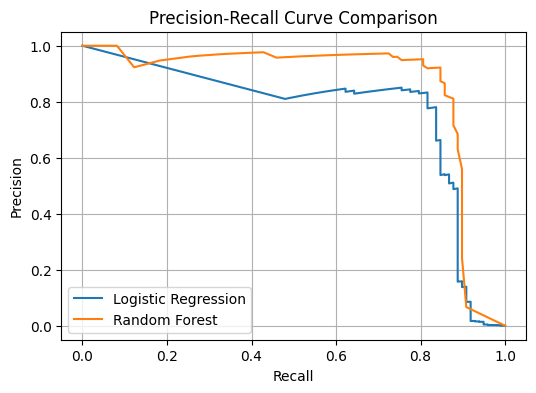

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

lr_prec, lr_rec, _ = precision_recall_curve(y_test, y_prob)
rf_prec, rf_rec, _ = precision_recall_curve(y_test, rf_prob)

plt.figure(figsize=(6,4))
plt.plot(lr_rec, lr_prec, label="Logistic Regression")
plt.plot(rf_rec, rf_prec, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

## Model Comparison

Random Forest significantly outperformed Logistic Regression in PR-AUC 
(0.85 vs 0.72), indicating stronger ranking capability under severe class imbalance.

The Precision-Recall curve shows that the tree-based model maintains 
higher precision across most recall regions, especially in high-recall settings.

This suggests that fraud detection in this dataset involves nonlinear feature interactions, 
which are better captured by ensemble methods.

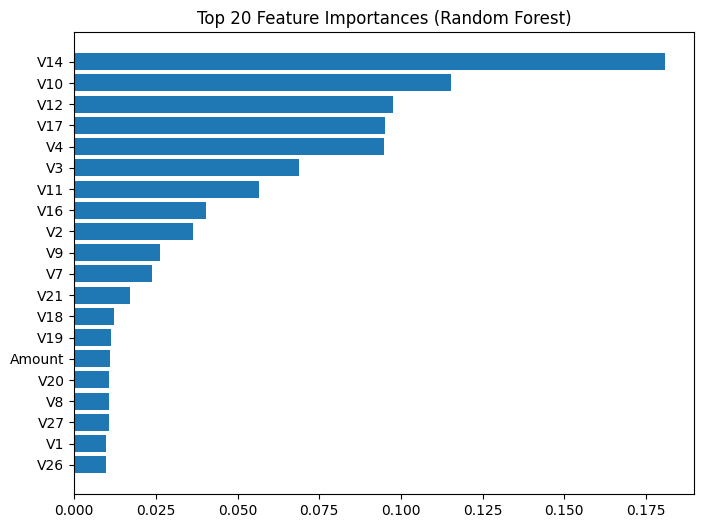

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns

feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top20 = feat_df.head(20)

plt.figure(figsize=(8,6))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

## Final Conclusion

- Fraud detection is highly imbalanced and requires PR-AUC evaluation.
- Logistic Regression provides a reasonable baseline but struggles with nonlinear patterns.
- Random Forest significantly improves ranking performance.
- Threshold tuning is essential for balancing false positives and false negatives in production settings.